# Summary of how to do some stuff with Barry that might be useful

### Basic imports

In [1]:
import sys 
sys.path.append("../")
import barry 
import numpy as np
import matplotlib.pyplot as plt 

### get a powerspectrum model with Barry

In [3]:
from barry.models import PowerBeutler2017 # - importing a powerspectrum model 

# Set up the model
model = PowerBeutler2017(
        fix_params=("om",), # by default only om will be fixed for models and alpha/epsilon will vary 
        # - can fix alphas if wanting to find best fits to some nuisance parameters only 
        smooth_type=None, # ?????
        recon=None, # for pre or post reconstruction (put 'sym' for recon) 
        postprocess=None, # ???
        smooth=False, # ???
        correction=None, # ???
        isotropic=False, # isotropic or anisotropic BAO fits 
        poly_poles=(0, 2), # which polynomials to fit ????????
        marg=None, # where to marginalise certain nuisance parameters (useful to set to 'full' for some cases) 
        dilate_smooth=True, # whether to include kprime (observed k in AP effect) in certain terms in the redshift space power spectrum model (rather than use k_true)
        n_poly=5, # number of polynomial terms to model for broadband power spectrum for BAO fits - this is just a modelling choice 
        n_data=1, # number of datasets to fit ????????? 
        data_share_bias=False,  # ?????
        data_share_poly=False, # ?????
        vary_neff=False, # whether to vary Neff cosmo parameter (just put here for testing stuff) 
        vary_phase_shift_neff=False, # whether to vary the phase-shift parameter (Neff induced phase shift in BAOs, can be fitted as additional parameter)
        use_classorcamb='CAMB' # can set to 'CLASS' to compute a power spectrum using CLASS instead of CAMB 
) 

cosmology = { # set values of cosmological parameters if desired (otherwise a default choice is used)
            "om": 0.31,
            "h0": 0.67,
            "z":  0.51,
            "ob": 0.048,
            "ns": 0.97,
            "mnu": 0.0,
            "reconsmoothscale": 15,
            "Neff": 3.044,
        }
model.set_cosmology(cosmology) # initialises self.camb object 
k = model.camb.ks
model.camb._generate_data() # - only needs to be run one time to calculate power spectrum for a given cosmology, 
# if already exists this step is unnecessary as Barry will read in the powerspectrum computed and saved previously 

pk = model.camb.get_data(cosmology["om"], Neff=3.044) # computes pk_linear at given redshift, pk_nonlinear at z and at z = 0.0,
# returns a dictionary with these and the baryon drag epoch sound horizon, ks, om, h0

print(pk)

{'om': 0.31, 'h0': 0.67, 'r_s': 99.61258608004817, 'ks': array([1.00000000e-04, 1.00693515e-04, 1.01391839e-04, ...,
       9.86272669e+01, 9.93112617e+01, 1.00000000e+02]), 'pk_lin': array([2.43543226e+02, 2.45180571e+02, 2.46828913e+02, ...,
       2.83337389e-04, 2.77982320e-04, 2.72727589e-04]), 'pk_nl_0': array([4.14798845e+02, 4.17587465e+02, 4.20394811e+02, ...,
       5.36647957e-02, 5.27421541e-02, 5.18349678e-02]), 'pk_nl_z': array([2.43543230e+02, 2.45180575e+02, 2.46828917e+02, ...,
       2.08809416e-02, 2.05175615e-02, 2.01603230e-02])}


### get the power spectrum moments (monopole, quadrupole, hexadecapole)

In [ ]:
model = PowerBeutler2017(
)
model.set_cosmology(cosmology) # initialises self.camb object 
ks = model.camb.ks
params_dict = {j.name: j.default for j in model.params} # for giving list of needed parameters to next function 

k, pk, poly = model.compute_power_spectrum(ks, params_dict, 
                                           smooth=False # if true gives the power spectrum with BAOs smoothed out 
                                          )
# pk[0] - isotropic case monopole , pk[2] is quadrupole, etc 

# for anistropic case: 
    # k[:,0], pk[0] # index in k lets mu vary, which changes k observed (pk has varying moments only)  


### its also possible to directly get the power spectrum using some other functions from barry.cosmology

In [8]:
from barry.cosmology.camb_generator import getCambGenerator # or ClassGenerator from camb.cosmology.class_generator if desired 

# you can get it to precompute and save models with varying choice of h0, Neff, omega_m (for neff need to set vary_neff = True AND neff_resolution > 1
c = getCambGenerator(redshift=0.1, Neff=3.044, h0_resolution=3, om_resolution=5)#, vary_neff=True, neff_resolution=3)

# c._generate_data() - you can then generator these models - although warning it can take some time 

# c.get_data() returns the same as model.camb.get_data() 
k, pk = c.ks, c.get_data(0.2, 0.75)["pk_lin"] # where the inputs are values for om, 
# h0 that are interpolated from the varying h0, omega_m power spectra generated 

### you can set up a power spectrum model, load some pre-processed data (such as the example here) and use it to plot a power spectrum model against the data with marginalization over annoying nuisance parameters

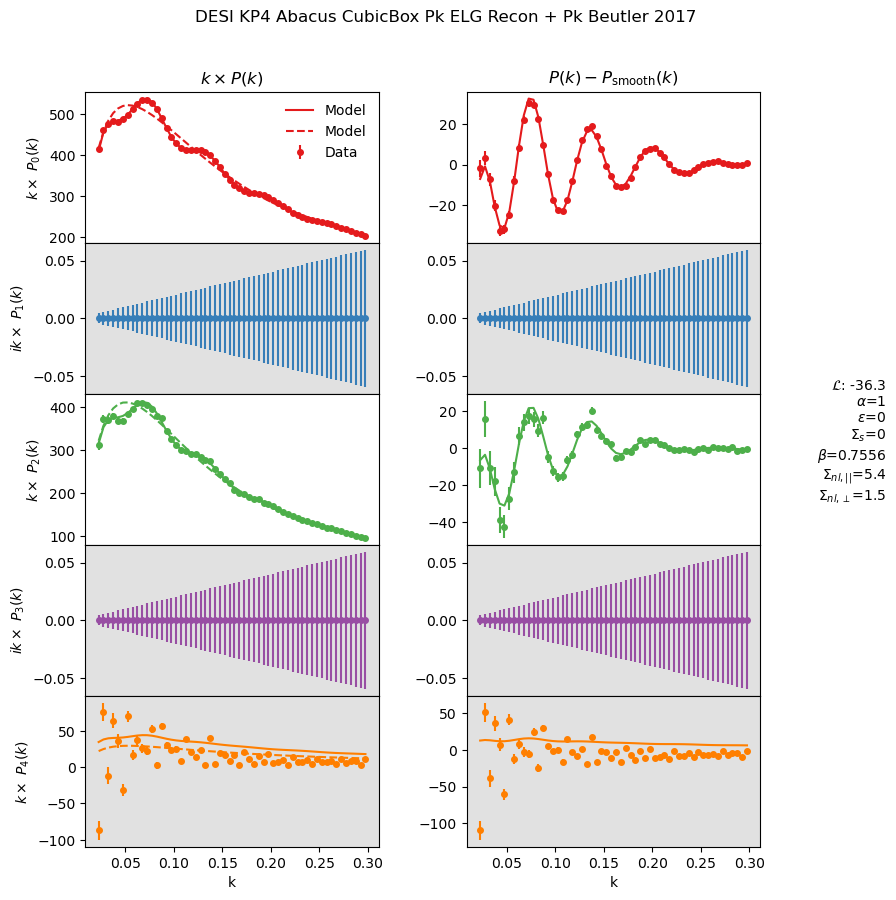

(169.79831634599347,
 93,
 array([ 1.52599203e+00, -3.06796183e+01,  7.23759978e+02, -9.86553661e+03,
         4.84389883e+04, -9.54010168e+04,  6.13470718e+04, -5.67639528e+01,
         1.30127727e+03, -2.33964846e+04,  1.33188023e+05, -3.18809032e+05,
         2.76334435e+05]),
 array([[[18245.08922726, 16587.00329847, 14654.04235936, 12855.48826244,
          11392.44044291, 10291.95530959,  9500.43605373,  8915.72907453,
           8428.71719089,  7949.09280745,  7422.56860487,  6836.8510349 ,
           6215.09476299,  5600.15200837,  5036.59323424,  4556.7699676 ,
           4174.52335785,  3885.65751267,  3672.39378525,  3509.35353028,
           3369.44852942,  3229.36481168,  3073.97653071,  2898.50891769,
           2707.72722014,  2512.62678816,  2326.05648386,  2158.87190758,
           2017.57472305,  1903.61463755,  1814.01116499,  1742.66554362,
           1682.38308589,  1626.18651837,  1568.32599504,  1505.41911077,
           1437.26245815,  1366.05705054,  1295.16361

In [11]:
# loading some pre-processed data 
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4

datafile="desi_kp4_abacus_cubicbox_pk_elg.pkl"

dataset_pk = PowerSpectrum_DESI_KP4(
recon='sym',
fit_poles=[0, 2],
min_k=0.02,
max_k=0.30,
realisation=None,          # realisation=None loads the average of all the realisations
num_mocks=1000,            # Used for Hartlap/Sellentin correction if correction=Correction.HARTLAP or Correction.SELLENTIN
reduce_cov_factor=25,       # if = 1 Use standard covariance, even for the average
datafile=datafile,  
data_location="/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles",
)

dataset_pk.set_realisation(None) # setting to None sets to the mean of the mocks, otherwise mocks go from realisations 0 - 24 


# now set up some choice of model 
model = PowerBeutler2017(
                recon='sym',                   
                isotropic=False,
                n_poly=6,                                 
                use_classorcamb='CLASS',
                dilate_smooth=True,
                marg='full'
)

# you can set the default values of parameters to something if desired (otherwise a default will exist for most things) 
# - commented out bit is only necessary if you want to include some kind of prior (gaussian or flat) 
# these nuisance parameters can be different depending on whether the model is isotropic or not. 
# can check using print(model.params) and various functions can be used to check if they are fixed or active in a fit / analysis 
model.set_default("sigma_nl_par", 5.4)#, min=0.0, max=20.0, sigma=4.0, prior="gaussian")
model.set_default("sigma_nl_perp", 1.5)#, min=0.0, max=20.0, sigma=4.0, prior="gaussian")
model.set_default("sigma_s", 0.0)# , min=0.0, max=20.0, sigma=4.0, prior="gaussian")

# to plot the data against the model do:
model.set_data(dataset_pk.get_data())
ks = model.camb.ks
params_dict = {j.name: j.default for j in model.params}

# running the following will give a model (mods) and smoothed model (smooths) and best fit chi square
# - having set model.marg='full' ensures that nuisance parameters for the broadband power spectrum and the galaxy bias are pre-marginalised over
new_chi_squared, dof, bband, mods, smooths = model.get_model_summary(params_dict)

# need to index with smooths[0][0] for example to get the smoothed monopole 

# to get the data stuff you might want to plot call: 
# ks = dataset_pk.ks 
# monopole = dataset_pk.data[:,0] # for monopole 
# err = np.sqrt(np.diag(dataset_pk.cov[0:56,0:56])) # errors on monopole measurements, given length of ks is 56 

# model.get_model_summary() is also called if the following function is used (which makes a nice plot for you) 
model.plot(params_dict)

## get a correlation function model with Barry

Beutler et al 2017 power spectrum model to BAO


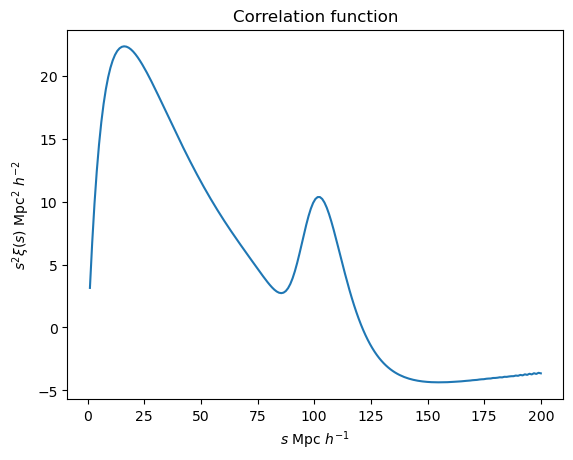

In [12]:
from barry.models import CorrBeutler2017 # - importing a powerspectrum model 
from barry.cosmology.pk2xi import *#pk2xi
# Set up the model
model = CorrBeutler2017(
        fix_params=("om",), # by default only om will be fixed for models and alpha/epsilon will vary 
        # - can fix alphas if wanting to find best fits to some nuisance parameters only 
        smooth_type=None, # ?????
        recon=None, # for pre or post reconstruction (put 'sym' for recon) 
        smooth=False, # ???
        correction=None, # ???
        isotropic=False, # isotropic or anisotropic BAO fits 
        poly_poles=(0, 2), # which polynomials to fit ????????
        marg=None, # where to marginalise certain nuisance parameters (useful to set to 'full' for some cases) 
        dilate_smooth=True, # whether to include kprime (observed k in AP effect) in certain terms in the redshift space power spectrum model (rather than use k_true)
        n_poly=3, # number of polynomial terms to model for broadband power spectrum for BAO fits - this is just a modelling choice  
        vary_neff=False, # whether to vary Neff cosmo parameter (just put here for testing stuff) 
        vary_phase_shift_neff=False, # whether to vary the phase-shift parameter (Neff induced phase shift in BAOs, can be fitted as additional parameter)
        use_classorcamb='CAMB' # can set to 'CLASS' to compute a power spectrum using CLASS instead of CAMB 
) 

cosmology = { # set values of cosmological parameters if desired (otherwise a default choice is used)
            "om": 0.31,
            "h0": 0.67,
            "z":  0.51,
            "ob": 0.048,
            "ns": 0.97,
            "mnu": 0.0,
            "reconsmoothscale": 15,
            "Neff": 3.044,
        }

model.parent.set_cosmology(cosmology) # initialises self.camb object for parent class from bao_power.py 
# in Barry the correlation function is computed by fourier transforming the power spectrum 
dat = model.parent.camb.get_data() # this loads / computes the data 
k, pk = dat["ks"], dat["pk_lin"]

model.pk2xi_0 = PowerToCorrelationGauss(k, ell=0) # setting up a function to fourier transform the power spectrum - some choices are available in 
# barry.cosmology (see pk2xi.py) 
#model.pk2xi_0 = PowerToCorrelationSphericalBessel(ell=0)

dists = np.linspace(0, 200, 200) # set up an array of length scales 
s, xi = dists, model.pk2xi_0(k, pk, dists) # get the correlation function by doing the fourier transform 

plt.plot(s, xi* (s**2))

print("Beutler et al 2017 power spectrum model to BAO")
plt.title("Correlation function")
plt.xlabel(r'$s$ $\mathrm{Mpc}$ $h^{-1}$')
plt.ylabel(r'$s^2 \xi(s)$ $\mathrm{Mpc}^2$ $h^{-2}$')
plt.show()

### now get the monopole / quadrupole 

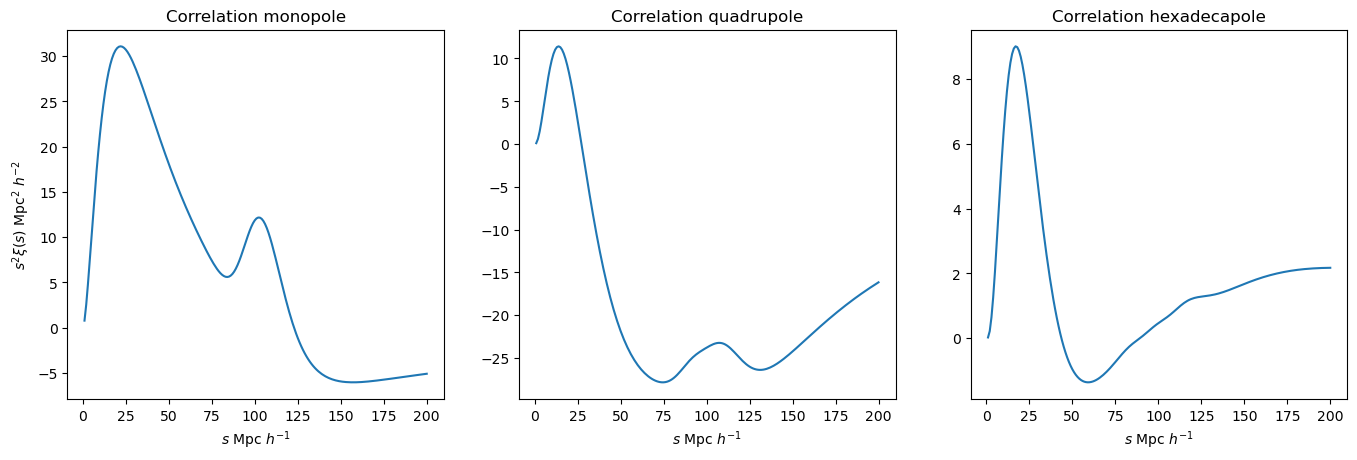

In [13]:
# model.pk2xi_0 = PowerToCorrelationGauss(k, ell=0)
# model.pk2xi_2 = PowerToCorrelationGauss(k, ell=2)
# model.pk2xi_4 = PowerToCorrelationGauss(k, ell=4)

model.pk2xi_0 = PowerToCorrelationSphericalBessel(k, ell=0)
model.pk2xi_2 = PowerToCorrelationSphericalBessel(k, ell=2)
model.pk2xi_4 = PowerToCorrelationSphericalBessel(k, ell=4)

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

params_dict = {j.name: j.default for j in model.params}
params_dict['beta'] = 0.525

dists = np.linspace(1, 200, 200)
s, xi, poly = model.compute_correlation_function(dists, params_dict, vary_neff=True)
ax1.plot(s, xi[0] * (s**2))
ax2.plot(s, xi[1] * (s**2))
ax3.plot(s, xi[2] * (s**2))

ax1.set_title("Correlation monopole")
ax2.set_title("Correlation quadrupole")
ax3.set_title("Correlation hexadecapole")

ax1.set_xlabel(r'$s$ $\mathrm{Mpc}$ $h^{-1}$')
ax2.set_xlabel(r'$s$ $\mathrm{Mpc}$ $h^{-1}$')
ax3.set_xlabel(r'$s$ $\mathrm{Mpc}$ $h^{-1}$')

ax1.set_ylabel(r'$s^2 \xi(s)$ $\mathrm{Mpc}^2$ $h^{-2}$')

plt.subplots_adjust(wspace=0.2, left=0, right=2.0)    
plt.show()

## load and plot some preprocessed data and a correlation function model

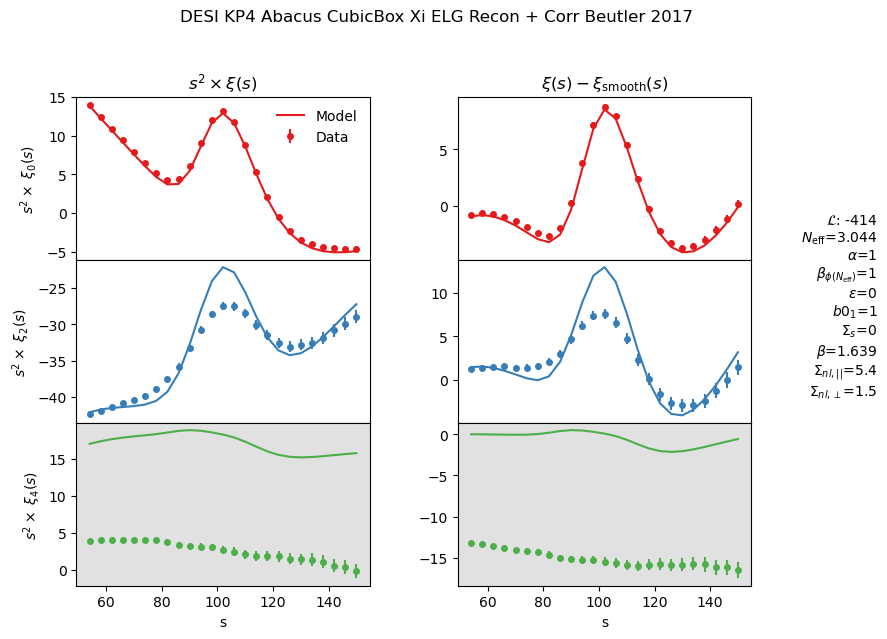

(734.9258110222952,
 31,
 array([-1.56578270e-05,  7.11657411e-03, -1.08344420e+00,  6.68716751e+01,
        -1.51943003e+03, -9.23455947e-05,  3.76046962e-02, -5.47887004e+00,
         3.64048133e+02, -6.55710611e+03]),
 [array([ 4.74094550e-03,  3.64203415e-03,  2.77683651e-03,  2.09124940e-03,
          1.54302147e-03,  1.10396657e-03,  7.65690513e-04,  5.50156582e-04,
          5.07949945e-04,  6.71935997e-04,  9.69964792e-04,  1.21369518e-03,
          1.23872678e-03,  1.03465246e-03,  7.11692395e-04,  3.88166408e-04,
          1.29100934e-04, -5.08725071e-05, -1.62807998e-04, -2.24578565e-04,
         -2.52384039e-04, -2.58493669e-04, -2.51487264e-04, -2.37055806e-04,
         -2.18867553e-04]),
  array([-0.01443977, -0.01240514, -0.01080208, -0.00950175, -0.00842084,
         -0.00749626, -0.00666279, -0.00584297, -0.00496968, -0.00404689,
         -0.00317715, -0.00250444, -0.00212632, -0.00203328, -0.00211337,
         -0.00222773, -0.00228501, -0.00225749, -0.00215756, -0.002

In [9]:
import sys 
sys.path.append("../")
import barry 
import numpy as np
import matplotlib.pyplot as plt 
from barry.models import CorrBeutler2017 # - importing a powerspectrum model 
from barry.cosmology.pk2xi import *#pk2xi
# loading some pre-processed data 
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.models.model import Correction # class for applying corrections to the likelihood function 

dataset_xi = CorrelationFunction_DESI_KP4(
    recon='sym',
    fit_poles=[0, 2,4],
    min_dist=52.0,
    max_dist=150.0,
    realisation=None,
    num_mocks=1000,
    reduce_cov_factor=25,
    datafile="desi_kp4_abacus_cubicbox_xi_elg.pkl",
    data_location="/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles",
            )

dataset_xi.set_realisation(None) # setting to None sets to the mean of the mocks, otherwise mocks go from realisations 0 - 24 

# now set up some choice of model 
model = CorrBeutler2017(
    recon=dataset_xi.recon, # sets recon or prerecon
    isotropic=dataset_xi.isotropic, # sets isotropic or not isotropic 
    marg="full", # sets marginalisation over nuisance parameters 
    poly_poles=dataset_xi.fit_poles, # sets poles to use 
    correction=Correction.NONE, # ??? 
    n_poly=5,    # 4 polynomial terms for Xi(s)
)

# you can set the default values of parameters to something if desired (otherwise a default will exist for most things) 
# - commented out bit is only necessary if you want to include some kind of prior (gaussian or flat) 
# these nuisance parameters can be different depending on whether the model is isotropic or not. 
# can check using print(model.params) and various functions can be used to check if they are fixed or active in a fit / analysis 
model.set_default("sigma_nl_par", 5.4)#, min=0.0, max=20.0, sigma=4.0, prior="gaussian")
model.set_default("sigma_nl_perp", 1.5)#, min=0.0, max=20.0, sigma=4.0, prior="gaussian")
model.set_default("sigma_s", 0.0)# , min=0.0, max=20.0, sigma=4.0, prior="gaussian")

# to plot the data against the model do:
model.set_data(dataset_xi.get_data())
ks = model.camb.ks
params_dict = {j.name: j.default for j in model.params}

# running the following will give a model (mods) and smoothed model (smooths) and best fit chi square
# - having set model.marg='full' ensures that nuisance parameters for the broadband power spectrum and the galaxy bias are pre-marginalised over
new_chi_squared, dof, bband, mods, smooths = model.get_model_summary(params_dict)

# need to index with smooths[0][0] for example to get the smoothed monopole 

# to get the data stuff you might want to plot call: 
# ks = dataset_pk.ks 
# monopole = dataset_pk.data[:,0] # for monopole 
# err = np.sqrt(np.diag(dataset_pk.cov[0:56,0:56])) # errors on monopole measurements, given length of ks is 56 

# model.get_model_summary() is also called if the following function is used (which makes a nice plot for you) 
model.plot(params_dict)